**References:**

- https://keras.io/examples/rl/ppo_cartpole/
- [Proximal Policy Optimization Algorithms](https://arxiv.org/abs/1707.06347)
- [OpenAI Spinning Up docs - PPO](https://spinningup.openai.com/en/latest/algorithms/ppo.html)
- [OpenAI Spinning Up Github - PPO](https://github.com/openai/spinningup/blob/master/spinup/algos/tf1/ppo/ppo.py)
- https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

In [1]:
import warnings

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


import tensorflow as tf
#from tf import keras as keras
import keras
from keras import layers

import numpy as np
import gym
import scipy.signal

In [3]:
np.seterr(all="ignore")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
import matplotlib, cv2
import matplotlib.pyplot as plt
import base64, io, os, time
import IPython, functools
#from tqdm import tqdm
import tensorflow_probability as tfp
import math
from typing import Optional
from gym import spaces, logger
from gym.utils import seeding

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [5]:
warnings.filterwarnings("ignore", message=".*Conversion of an array with ndim > 0 to a scalar.*")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Functions and class

In [6]:
class CartPoleEnvCustomized_with_pid(gym.Env):
    """
    ### Description
    This environment corresponds to the version of the cart-pole problem
    described by Barto, Sutton, and Anderson in ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
    A pole is attached by an un-actuated joint to a cart, which moves along a
    frictionless track. The pendulum starts upright, and the goal is to prevent
    it from falling over by increasing and reducing the cart's velocity.
    ### Action Space
    The agent take a 1-element vector for actions.
    The action space is `(action)` in `[0, 1]`, where `action` is used to push
    the cart with a fixed amount of force:
    | Num | Action                 |
    |-----|------------------------|
    | 0   | Push cart to the left  |
    | 1   | Push cart to the right |
    Note: The amount the velocity is reduced or increased is not fixed as it depends on the angle the pole is pointing.
    This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it
    ### Observation Space
    The observation is a `ndarray` with shape `(4,)` where the elements correspond to the following:
    | Num | Observation           | Min                  | Max                |
    |-----|-----------------------|----------------------|--------------------|
    | 0   | Cart Position         | -4.8*                 | 4.8*                |
    | 1   | Cart Velocity         | -Inf                 | Inf                |
    | 2   | Pole Angle            | ~ -0.418 rad (-24°)** | ~ 0.418 rad (24°)** |
    | 3   | Pole Angular Velocity | -Inf                 | Inf                |
    **Note:** above denotes the ranges of possible observations for each element, but in two cases this range exceeds the
    range of possible values in an un-terminated episode:
    - `*`: the cart x-position can be observed between `(-4.8, 4.8)`, but an episode terminates if the cart leaves the
    `(-2.4, 2.4)` range.
    - `**`: Similarly, the pole angle can be observed between  `(-.418, .418)` radians or precisely **±24°**, but an episode is
    terminated if the pole angle is outside the `(-.2095, .2095)` range or precisely **±12°**
    ### Rewards
    Reward is 1 for every step taken, including the termination step. The threshold is 475 for v1.
    ### Starting State
    All observations are assigned a uniform random value between (-0.05, 0.05)
    ### Episode Termination
    The episode terminates of one of the following occurs:
    1. Pole Angle is more than ±12°
    2. Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
    3. Episode length is greater than 500 (200 for v0)
    ### Arguments
    No additional arguments are currently supported.
    """

    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 50}

    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = "euler"


        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = np.array(
            [
                self.x_threshold * 2,
                np.finfo(np.float32).max,
                self.theta_threshold_radians * 2,
                np.finfo(np.float32).max,
            ],
            dtype=np.float32,
        )

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

        ### Customization changes ######
        self.DCMotor_radius = 0.15 #0.2 #### chnge actualy diameter and arm len for rotation
        '''add ElectricalDCMotorEnv to the CartPole class
        and assign values to
        Resistor_R, inductor_L, torque_const_Kt and bemf_const_Ke'''
        self.DCMotorModel = ElectricalDCMotorEnv()
        self.DCMotorModel.tau = self.tau
        self.DCMotorModel.Resistor_R = 1.0
        self.DCMotorModel.inductor_L = 0.1
        self.DCMotorModel.torque_const_Kt = 1.0
        self.DCMotorModel.bemf_const_Ke = 1.0
        ####


    def step(self, action):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg

        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag #+/-10N
        torque_wanted = force*self.DCMotor_radius

        ### Customization changes #####
        ''' set current refrence value current_ref and
        caclulate actual applied force F based DC motor model and PID control at
        DCMotorModel.step function
        '''
        current_ref = torque_wanted/self.DCMotorModel.torque_const_Kt
        #F = self.DCMotorModel.step(current_ref = current_ref,x_dot = x_dot)
        torque_actual = self.DCMotorModel.step(current_ref = current_ref,
                                   x_dot = x_dot/self.DCMotor_radius)
        F = torque_actual/self.DCMotor_radius
        #F = force #ideal env
        ###

        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            F + self.polemass_length * theta_dot ** 2 * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == "euler":
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        done = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        if not done: # if we inside the valid range
            reward = 1.0

        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0

        else:
            if self.steps_beyond_done == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state, dtype=np.float32), reward, done, {} ,torque_wanted, torque_actual


    def reset(self, return_info = False, options = None):
        #super().reset(seed=seed)
        self.state = np.random.uniform(low=-0.05, high=0.05, size=(4,))
        self.DCMotorModel.current = 0.0
        self.DCMotorModel.current_error = 0.0
        self.DCMotorModel.current_error_acc = 0.0
        self.DCMotorModel.current_error_prev = 0.0
        self.steps_beyond_done = None

        if not return_info:
            return np.array(self.state, dtype=np.float32)
        else:
            return np.array(self.state, dtype=np.float32), {}

    def render(self, mode="human"):
        screen_width = 600
        screen_height = 400

        world_width = self.x_threshold * 2
        scale = screen_width / world_width
        carty = 100  # TOP OF CART
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            #from gym.utils import pyglet_rendering
            from gym.envs.classic_control import rendering as pyglet_rendering

            self.viewer = pyglet_rendering.Viewer(screen_width, screen_height)
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = pyglet_rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = pyglet_rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            l, r, t, b = (
                -polewidth / 2,
                polewidth / 2,
                polelen - polewidth / 2,
                -polewidth / 2,
            )
            pole = pyglet_rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            pole.set_color(0.8, 0.6, 0.4)
            self.poletrans = pyglet_rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            self.axle = pyglet_rendering.make_circle(polewidth / 2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(0.5, 0.5, 0.8)
            self.viewer.add_geom(self.axle)
            self.track = pyglet_rendering.Line((0, carty), (screen_width, carty))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

            self._pole_geom = pole

        if self.state is None:
            return None

        # Edit the pole polygon vertex
        pole = self._pole_geom
        l, r, t, b = (
            -polewidth / 2,
            polewidth / 2,
            polelen - polewidth / 2,
            -polewidth / 2,
        )
        pole.v = [(l, b), (l, t), (r, t), (r, b)]

        x = self.state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(-x[2])

        return self.viewer.render(return_rgb_array=mode == "rgb_array")

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
class ElectricalDCMotorEnv():

      def __init__(self):
        self.Resistor_R = 1.0
        self.inductor_L = 0.1
        self.torque_const_Kt = 1.0
        self.bemf_const_Ke = 1.0
        self.tau = 0.02
        #

        self.Kp = 4.3 #5.0 #50.0
        self.Ki = 1.0 #10.0 #3.0
        self.Kd = 10.0**(-6)
        self.aL=10.0**(-3) #Low pass parameter
        self.aH = 10.0**2 #High pass parameter

        #
        self.current = 0.0
        self.current_error = 0.0
        self.current_error_acc = 0.0
        self.current_error_prev = 0.0
        self.voltage_input = 0.0
        self.xdot = 0.0
        self.PID_Discretization = "Simple" #"Backward", " "Bilinear" , "Forward" "Simple"


      def step(self, current_ref, x_dot):
        aL = self.aL
        aH = self.aH
        self.current_error = current_ref-self.current
        delta_error = self.current_error-self.current_error_prev

        if self.PID_Discretization == "Simple":
          self.current_error_acc += self.current_error*self.tau
          HP_delta_error = delta_error

        elif self.PID_Discretization == "Backward":
          self.current_error_acc = (self.current_error_acc+(self.current_error)*self.tau)/(1+aL*self.tau) #Low Pass
          HP_delta_error = (self.current_error + aH*delta_error)/(1+aL*self.tau)#High Pass

        elif self.PID_Discretization == "Bilinear":
          error_avg = (self.current_error+self.current_error_prev)/2
          self.current_error_acc =  ((1-aL*self.tau/2)*self.current_error_acc + error_avg*self.tau)/(1+aL*self.tau/2)#Low Pass
          HP_delta_error =  ((1-aL*self.tau/2)*self.current_error + aH*delta_error)/(1+aL*self.tau/2)#High Pass

        else:
          self.current_error_acc = (1-aL*self.tau)*self.current_error_acc+(self.current_error_prev)*self.tau #Low Pass
          HP_delta_error = (1-aH*self.tau)*self.current_error + aH*delta_error #High Pass

        P = self.Kp*self.current_error
        I = self.Ki*self.current_error_acc
        D = self.Kd*HP_delta_error/self.tau
        voltage_BEMF = x_dot*self.bemf_const_Ke
        voltage_input = P+I+D+voltage_BEMF + 0.7*current_ref
        voltage_input = np.clip(voltage_input, -20, 20)

        self.current_error_prev = 0+self.current_error
        self.current += self.tau*(voltage_input-voltage_BEMF-self.current*self.Resistor_R)/self.inductor_L
        self.voltage_input = voltage_input
        self.xdot = x_dot
        F=self.torque_const_Kt*self.current

        return F # return applied torque

In [8]:

def discounted_cumulative_sums(x, discount):
    # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Buffer:
    # Buffer for storing trajectories
    def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
        # Buffer initialization
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros(size, dtype=np.int32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1

    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            deltas, self.gamma * self.lam
        )
        self.return_buffer[path_slice] = discounted_cumulative_sums(
            rewards, self.gamma
        )[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer, self.trajectory_start_index = 0, 0
        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.logprobability_buffer,
        )

#output_activation=None
def mlp(x, sizes, activation=keras.activations.tanh,
        output_activation=None):
    # Build a feedforward neural network
    for size in sizes[:-1]:
        x = layers.Dense(units=size, activation=activation)(x)
    return layers.Dense(units=sizes[-1], activation=output_activation)(x)



def logprobabilities(logits, a):
    # Compute the log-probabilities of taking actions a by using the logits (i.e. the output of the actor)
    logprobabilities_all = keras.ops.log_softmax(logits)
    logprobability = keras.ops.sum(
        keras.ops.one_hot(a, num_actions) * logprobabilities_all, axis=1
    )
    return logprobability


seed_generator = keras.random.SeedGenerator(1337)


# Sample action from actor
@tf.function
def sample_action(observation):
    logits = actor(observation)
    action = keras.ops.squeeze(
        keras.random.categorical(logits, 1, seed=seed_generator), axis=1
    )
    return logits, action


# Train the policy by maxizing the PPO-Clip objective
@tf.function
def train_policy(
    observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        ratio = keras.ops.exp(
            logprobabilities(actor(observation_buffer), action_buffer)
            - logprobability_buffer
        )
        min_advantage = keras.ops.where(
            advantage_buffer > 0,
            (1 + clip_ratio) * advantage_buffer,
            (1 - clip_ratio) * advantage_buffer,
        )

        policy_loss = -keras.ops.mean(
            keras.ops.minimum(ratio * advantage_buffer, min_advantage)
        )
    policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
    policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))

    kl = keras.ops.mean(
        logprobability_buffer
        - logprobabilities(actor(observation_buffer), action_buffer)
    )
    kl = keras.ops.sum(kl)
    return kl


# Train the value function by regression on mean-squared error
@tf.function
def train_value_function(observation_buffer, return_buffer):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        value_loss = keras.ops.mean((return_buffer - critic(observation_buffer)) ** 2)
    value_grads = tape.gradient(value_loss, critic.trainable_variables)
    value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))


## Hyperparameters

In [9]:
# Hyperparameters of the PPO algorithm
steps_per_epoch = 4000
epochs = 60 # 40 #30
gamma = 0.99
clip_ratio = 0.2
policy_learning_rate = 3e-4
value_function_learning_rate = 1e-3
train_policy_iterations = 80
train_value_iterations = 80
lam = 0.97
target_kl = 0.01
hidden_sizes = (64, 64)

# True if you want to render the environment
render = False

## Initializations

In [10]:
# Initialize the environment and get the dimensionality of the
# observation space and the number of possible actions
env = CartPoleEnvCustomized_with_pid()
observation_dimensions = env.observation_space.shape[0]
num_actions = env.action_space.n

# Initialize the buffer
buffer = Buffer(observation_dimensions, steps_per_epoch)

# Initialize the actor and the critic as keras models
observation_input = keras.Input(shape=(observation_dimensions,), dtype="float32")
logits = mlp(observation_input, list(hidden_sizes) + [num_actions])
actor = keras.Model(inputs=observation_input, outputs=logits)
value = keras.ops.squeeze(mlp(observation_input, list(hidden_sizes) + [1]), axis=1)
critic = keras.Model(inputs=observation_input, outputs=value)

# Initialize the policy and the value function optimizers
policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)

# Initialize the observation, episode return and episode length
#observation, _ = env.reset()
observation = env.reset()
episode_return, episode_length = 0, 0

In [11]:
#actor.summary()

In [12]:
#critic.summary()

## Train

In [13]:
avg_reward_list = []
avg_episode_length_list = []
num_episodes_list = []

# Iterate over the number of epochs
for epoch in range(epochs):
    # Initialize the sum of the returns, lengths and number of episodes for each epoch
    sum_return = 0
    sum_length = 0
    num_episodes = 0

    # Iterate over the steps of each epoch
    for t in range(steps_per_epoch):
        if render:
            env.render()

        # Get the logits, action, and take one step in the environment
        observation = observation.reshape(1, -1)
        logits, action = sample_action(observation)
        #observation_new, reward, done, _, _ = env.step(action[0].numpy())
        observation_new, reward, done, _ ,torque_wanted, torque_actual= env.step(action[0].numpy().item())
        x_obs = observation_new[0]
        reward= reward*(x_obs>-0.1 and x_obs<0.1)
        episode_return += reward
        episode_length += 1

        # Get the value and log-probability of the action
        value_t = critic(observation)
        logprobability_t = logprobabilities(logits, action)
        # Store obs, act, rew, v_t, logp_pi_t
        buffer.store(observation, action, reward, value_t, logprobability_t)
        # Update the observation
        observation = observation_new

        # Finish trajectory if reached to a terminal state
        terminal = done
        if terminal or (t == steps_per_epoch - 1):
            last_value = 0 if done else critic(observation.reshape(1, -1))
            buffer.finish_trajectory(last_value)
            sum_return += episode_return
            sum_length += episode_length
            num_episodes += 1
            #observation, _ = env.reset()
            observation = env.reset()
            episode_return, episode_length = 0, 0

    # Get values from the buffer
    (
        observation_buffer,
        action_buffer,
        advantage_buffer,
        return_buffer,
        logprobability_buffer,
    ) = buffer.get()

    # Update the policy and implement early stopping using KL divergence
    for _ in range(train_policy_iterations):
        kl = train_policy(
            observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
        )
        if kl > 1.5 * target_kl:
            # Early Stopping
            break

    # Update the value function
    for _ in range(train_value_iterations):
        train_value_function(observation_buffer, return_buffer)

    # Print  No. of episodes, avg. return and avg. length for each epoch
    avg_return = sum_return / num_episodes
    avg_episode_length = sum_length / num_episodes
    avg_reward_list.append(avg_return)
    avg_episode_length_list.append(avg_episode_length)
    num_episodes_list.append(num_episodes)
    print(
        f" Epoch: {epoch + 1}. No. of Episodes: {num_episodes}. Avg. Return: {avg_return:.2f}. Avg. Length: {avg_episode_length:.2f}"
    )

 Epoch: 1. No. of Episodes: 175. Avg. Return: 18.86. Avg. Length: 22.86
 Epoch: 2. No. of Episodes: 150. Avg. Return: 21.22. Avg. Length: 26.67
 Epoch: 3. No. of Episodes: 106. Avg. Return: 29.69. Avg. Length: 37.74
 Epoch: 4. No. of Episodes: 89. Avg. Return: 34.01. Avg. Length: 44.94
 Epoch: 5. No. of Episodes: 71. Avg. Return: 39.55. Avg. Length: 56.34
 Epoch: 6. No. of Episodes: 56. Avg. Return: 46.45. Avg. Length: 71.43
 Epoch: 7. No. of Episodes: 44. Avg. Return: 48.84. Avg. Length: 90.91
 Epoch: 8. No. of Episodes: 44. Avg. Return: 49.23. Avg. Length: 90.91
 Epoch: 9. No. of Episodes: 40. Avg. Return: 52.17. Avg. Length: 100.00
 Epoch: 10. No. of Episodes: 35. Avg. Return: 51.03. Avg. Length: 114.29
 Epoch: 11. No. of Episodes: 29. Avg. Return: 60.72. Avg. Length: 137.93
 Epoch: 12. No. of Episodes: 27. Avg. Return: 49.22. Avg. Length: 148.15
 Epoch: 13. No. of Episodes: 22. Avg. Return: 50.09. Avg. Length: 181.82
 Epoch: 14. No. of Episodes: 17. Avg. Return: 77.71. Avg. Length:

In [14]:
print(f"Total No. of episodes:  {np.array(num_episodes_list).sum()}")

Total No. of episodes:  1101


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


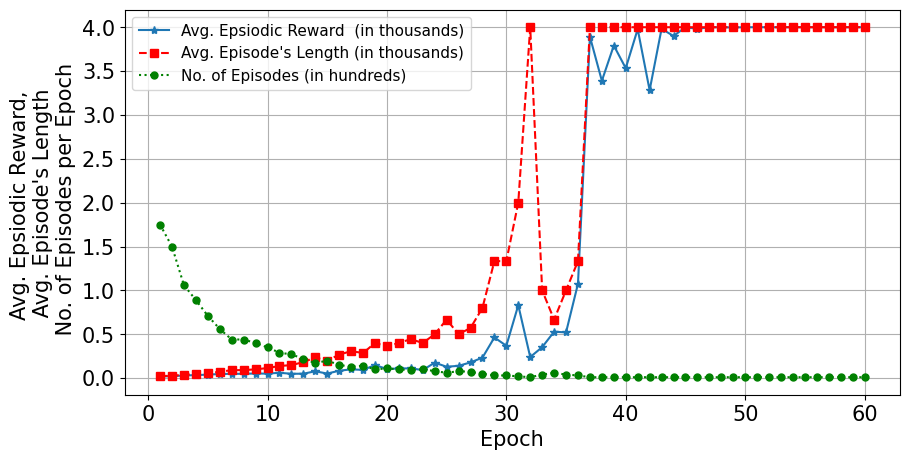

In [33]:
# Plotting graph
# Epochs vs: Avg. Epsiodic Rewards, Avg. length of epoch
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(np.arange(len(avg_reward_list))+1,np.array(avg_reward_list)/1000, marker="*", label = "Avg. Epsiodic Reward  (in thousands)")
plt.plot(np.arange(len(avg_episode_length_list))+1,np.array(avg_episode_length_list)/1000, "--", marker="s",color="red", label = "Avg. Episode's Length (in thousands)")
plt.plot(np.arange(len(num_episodes_list))+1, np.array(num_episodes_list)/100,
         ':',color="green", marker=".", markersize=10, label = "No. of Episodes (in hundreds)")
plt.xlabel("Epoch")
plt.ylabel("Avg. Epsiodic Reward, \n Avg. Episode's Length \n No. of Episodes per Epoch")
plt.grid()
plt.legend(fontsize = 11)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


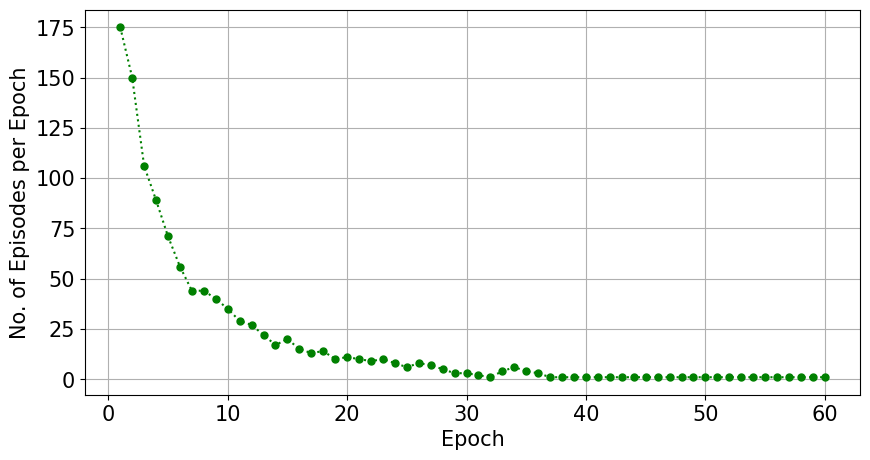

In [16]:
# Plotting graph
# Epochs versus No. of Episodes per Epoch
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(np.arange(len(num_episodes_list))+1, num_episodes_list,
         ':',label = "No. of Episodes",color="green", marker=".", markersize=10)
plt.xlabel("Epoch")
plt.ylabel("No. of Episodes per Epoch")
plt.grid()
plt.show()

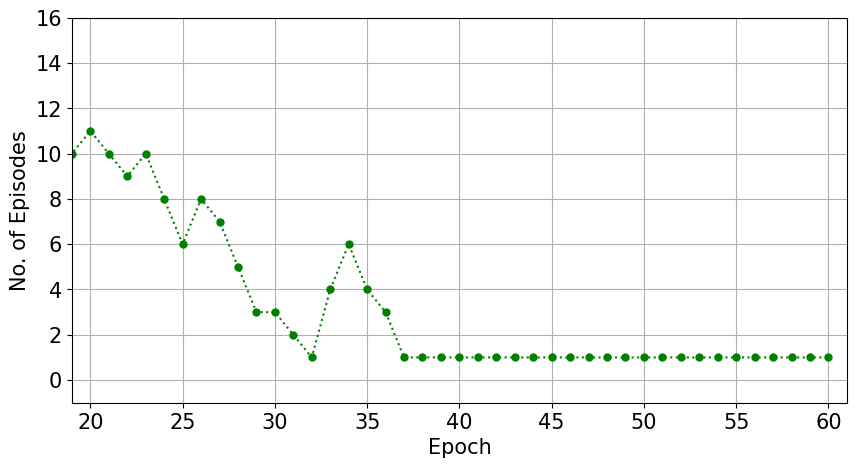

In [17]:
# Plotting graph
# Epochs versus No. of Episodes per Epoch
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(np.arange(len(num_episodes_list))+1, num_episodes_list,
         ':',label = "No. of Episodes",color="green", marker=".", markersize=10)
plt.xlabel("Epoch")
plt.ylabel("No. of Episodes")
plt.xlim(epoch-40, epochs+1)
plt.ylim(-1, 16)
plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
observation = env.reset()
save_observation = []
save_wanted_torque = []
save_actual_torque = []

done=False
t=0
while not done and t<501:
    # using our observation, choose an action and take it in the environment
    # Get the logits, action, and take one step in the environment
    observation = observation.reshape(1, -1)
    logits, action = sample_action(observation)
    #observation_new, reward, done, _, _ = env.step(action[0].numpy())
    observation_new, reward, done, _ ,torque_wanted, torque_actual= env.step(action[0].numpy().item())
    observation = observation_new
    save_observation.append(observation)
    save_wanted_torque.append(torque_wanted)
    save_actual_torque.append(torque_actual)
    t+=1

if done:
  print("Pole fell down during test")
else:
  print("Pole NOT fell down during test")

Pole NOT fell down during test


In [19]:
dt=env.tau
time_= np.linspace(start = 0, stop = len(save_wanted_torque)* dt,
                   num=len(save_wanted_torque) )


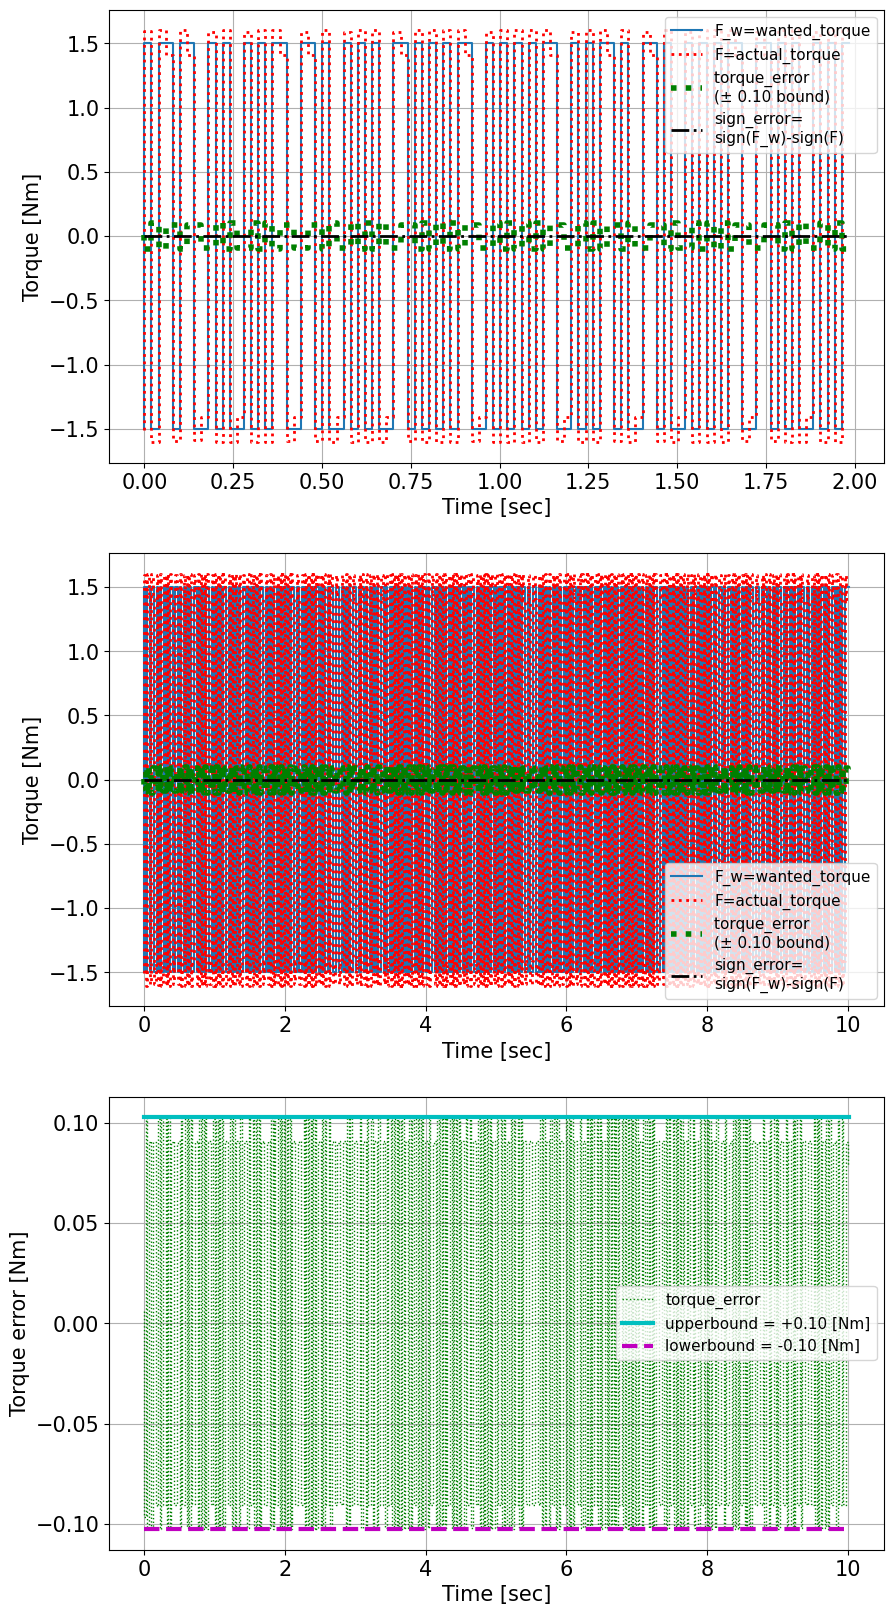

In [20]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(20)

sign_error = np.sign(np.array(save_wanted_torque)) - np.sign(np.array(save_actual_torque))
force_error = np.array(save_wanted_torque) - np.array(save_actual_torque) ### add
force_error_max = np.max(np.abs(force_error))


plt.subplot(3, 1, 1)
plt.step(time_[:int(len(time_)/5)], save_wanted_torque[:int(len(time_)/5)],label = "F_w=wanted_torque")
plt.step(time_[:int(len(time_)/5)], save_actual_torque[:int(len(time_)/5)],':',label = "F=actual_torque",color="red",linewidth = 2)
plt.step(time_[:int(len(time_)/5)], force_error[:int(len(time_)/5)],':',
         label = f"torque_error \n(± {force_error_max:.2f} bound)",
         color="green",linewidth = 4) ### add
plt.step(time_[:int(len(time_)/5)], sign_error[:int(len(time_)/5)],'-.',label = "sign_error=\nsign(F_w)-sign(F)",color="black",linewidth = 2)
plt.legend(fontsize = 11)
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Torque [Nm]')

plt.subplot(3, 1, 2)
plt.step(time_, save_wanted_torque,label = "F_w=wanted_torque")
plt.step(time_, save_actual_torque,':',label = "F=actual_torque",color="red",linewidth = 2)
plt.step(time_, force_error,':',
         label = f"torque_error \n(± {force_error_max:.2f} bound)",
         color="green",linewidth = 4) ### add
plt.step(time_, sign_error,'-.',label = "sign_error=\nsign(F_w)-sign(F)",color="black",linewidth = 2)
plt.legend(fontsize = 11)
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Torque [Nm]')

plt.subplot(3, 1, 3)
plt.step(time_, force_error,':',
         label = "torque_error",
         color="green",linewidth = 1) ### add
plt.step(time_, force_error*0+force_error_max,'-',
         label = f"upperbound = +{force_error_max:.2f} [Nm]",
         color="c",linewidth = 3) ### add
plt.step(time_, force_error*0-force_error_max,'--',
         label = f"lowerbound = -{force_error_max:.2f} [Nm]",
         color="m",linewidth = 3) ### add
plt.xlabel('Time [sec]')
plt.ylabel('Torque error [Nm]')
plt.legend(fontsize = 11)
plt.grid()

plt.show()

In [21]:
# distribution to 4 observation parameters

position = []
velocity = []
angle = []
angular_velocity = []
for observ in save_observation:
  for index,value in enumerate(observ):
    if index == 0:
      position.append(value)
    if index == 1:
      velocity.append(value)
    if index == 2:
      angle.append(value)
    if index == 3:
      angular_velocity.append(value)

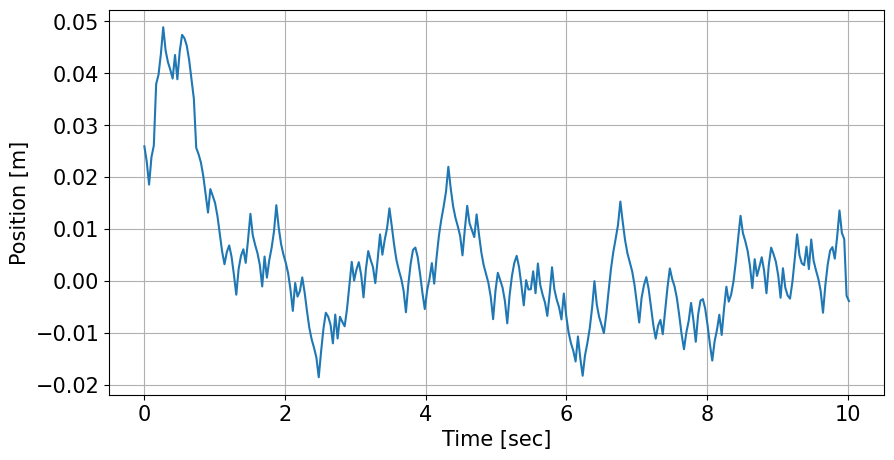

In [22]:
from scipy.interpolate import make_interp_spline, BSpline

time_position = np.linspace(start = 0, stop = len(position)* dt,num=len(position))##############################################
#time_position , position
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_position[-1] , 300)

spl = make_interp_spline(time_position, position, k=3)  # type: BSpline
power_smooth = spl(xnew)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(xnew, power_smooth)
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Position [m]')
plt.show()

In [23]:
print(len(position))


501


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


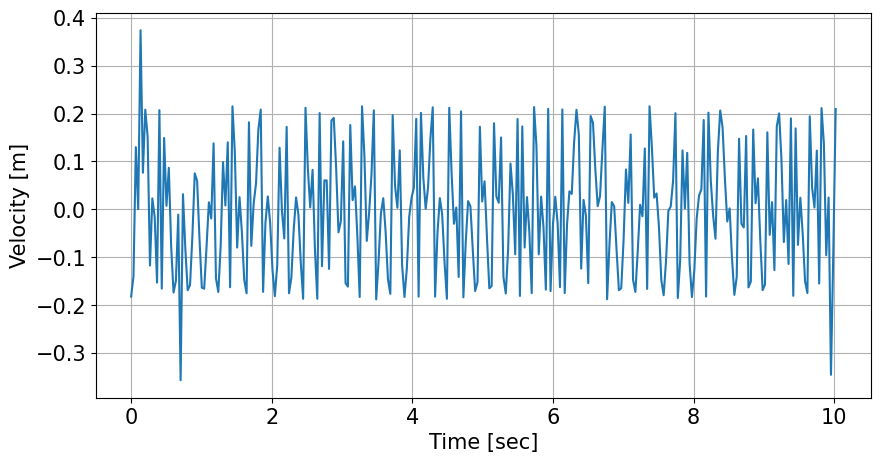

In [24]:
from scipy.interpolate import make_interp_spline, BSpline

time_velocity = np.linspace(start = 0, stop = len(velocity)* dt,num=len(velocity))
#time_velocity , velocity
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_velocity[-1] , 300)

spl = make_interp_spline(time_velocity, velocity, k=3)  # type: BSpline
power_smooth = spl(xnew)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(xnew, power_smooth)
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Velocity [m]')
plt.show()

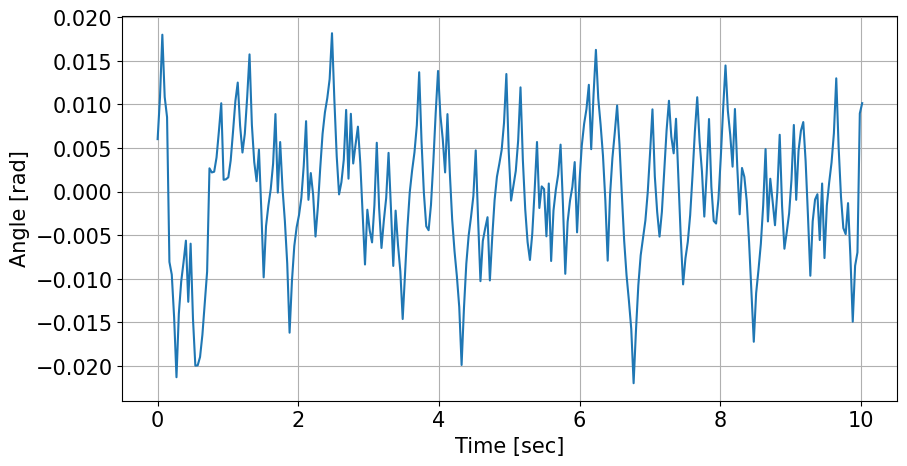

In [25]:
from scipy.interpolate import make_interp_spline, BSpline

time_angle = np.linspace(start = 0, stop = len(angle)* dt,num=len(angle))
#time_angle , angle
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_angle[-1] , 300)

spl = make_interp_spline(time_angle,angle, k=3)  # type: BSpline
power_smooth = spl(xnew)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(xnew, power_smooth)
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Angle [rad]')
plt.show()

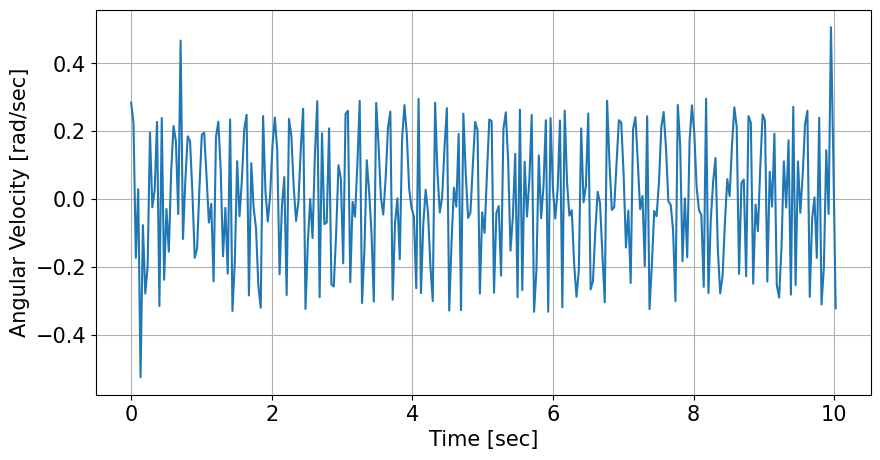

In [26]:
from scipy.interpolate import make_interp_spline, BSpline

time_angular_velocity = np.linspace(start = 0, stop = len(angular_velocity)* dt,num=len(angular_velocity))
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_angular_velocity[-1] , 300)

spl = make_interp_spline(time_angular_velocity, angular_velocity, k=3)  # type: BSpline
power_smooth = spl(xnew)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(xnew, power_smooth)
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Angular Velocity [rad/sec]')
plt.show()